# Problem 1

In this problem we will train a convolutional neural network for image classification using transfer learning. Transfer learning involves training a base network from scratch on a very large dataset (e.g., Imagenet1K with 1.2 M images and 1K categories) and then using this base network either as a feature extractor or as an initialization network for target task. Thus two major transfer learning scenarios are as follows:

- Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.

- Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

## (a)

We use **CIFAR100** as our dastaset. 

We use the introduction from official website:

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

In [4]:
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR100
from torchvision.models import resnet50
import torch.nn as nn

In [5]:
# prepare_dataset
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CIFAR100(root='./cached_datasets', train=True, transform=train_transform, download=True)
test_dataset = CIFAR100(root='./cached_datasets', train=False, transform=test_transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


### Dataset Description

CIFAR100 is 

### Display Images

We choose the class 0 and class 1 to display.

Files already downloaded and verified


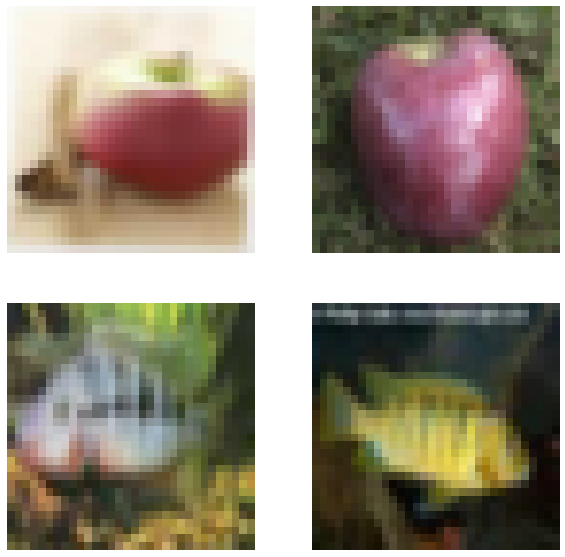

In [25]:
train_dataset = CIFAR100(root='./cached_datasets', train=True, transform=None, download=True)

def select_class(class_num=0):
    for i in range(len(train_dataset)):
        if train_dataset.targets[i] == class_num:
            yield train_dataset.data[i]

# display PIL Image
import matplotlib.pyplot as plt
g0 = select_class(class_num=0)
g1 = select_class(class_num=1)
plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(next(g0))
    plt.axis('off')

for i in range(2):
    plt.subplot(2,2,i+3)
    plt.imshow(next(g1))
    plt.axis('off')


We display the class 0 and clas 1

The target feature is various features of the objects.

## (b)
First finetune by setting the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers. Keep batch size of 64 and train for 200-300 epochs or until model converges well. You will use a multi-step learning rate schedule and decay by a factor of 0.1 ( γ = 0.1 in the link below). You can choose steps at which you want to decay the learning rate but do 3 drops during the training. So the first drop will bring down the learning rate to 0.0001, second to 0.00001, third to 0.000001. For example, if training for 200 epochs, first drop can happen at epoch 60, second at epoch 120 and third at epoch 180. (8)

In [26]:
import pytorch_lightning as pl
import torchmetrics
import torch
from torch.optim.lr_scheduler import MultiStepLR

class ResNetLightningModule(pl.LightningModule):
    def __init__(self, hidden_size, output_size, optimizer_name='adam', use_dropout=False):
        super(ResNetLightningModule, self).__init__()
        self.model = resnet50(pretrained=True, progress=True)
        self.model.fc = nn.Linear(2048, 100)

        self.loss_fn = nn.CrossEntropyLoss()
        self.acc_metric = torchmetrics.Accuracy()
        self.optimizer_name = optimizer_name
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.acc_metric(y_hat, y)
        self.log('train_loss', loss, prog_bar=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=False, on_epoch=True)
        logs = {'train_loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.acc_metric(y_hat, y)
        self.log('val_loss', loss, prog_bar=False, on_epoch=True)
        self.log('val_acc', acc, prog_bar=False, on_epoch=True)

    def configure_optimizers(self):
        lr = 0.001
        momentum = 0.9
        batch_size = 64
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)

        # multi_step_lr_scheduler
        # For example, if training for 200 epochs, first drop can happen at epoch 60, second at epoch 120 and third at epoch 180.
        scheduler = MultiStepLR(optimizer, milestones=[60, 120, 180], gamma=0.1)
        return [optimizer], [scheduler]

### Process Results

All Layer Part

In [6]:
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("xiang-pan/NYU_DL_Sys-HW4_problem1")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 
    # print(run)
#     # run.config is the input metrics.
#     # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config_list.append(config) 

#     # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

all_df.to_csv("./problem1/1.csv")


In [8]:
import pandas as pd
all_df = pd.read_csv("./problem1/1.csv", index_col=0)
all_df["lr"] =  [i.split("_")[-1] for i in all_df["name"]]
all_df

,name,_wandb,_timestamp,train_acc_step,train_acc_epoch,train_loss_epoch,trainer/global_step,_step,epoch,test_loss,train_loss_step,_runtime,test_acc,lr
0,fix_backbone_0.1,{'runtime': 6665},1649328205,0.8750,0.99972,0.001441,156400,3328,200,2.326900,0.586030,6669,0.6254,0.1
1,fix_backbone_0.0001,{'runtime': 6502},1649328037,1.0000,0.99982,0.001364,156400,3328,200,2.292322,0.013677,6501,0.6268,0.0001
2,fix_backbone_0.001,{'runtime': 6642},1649328179,0.9375,0.99960,0.001527,156400,3328,200,2.355145,0.079179,6644,0.6203,0.001
3,All_Layer_ 0.1,{'runtime': 6575},1649298994,0.7500,0.99958,0.001589,156400,3328,200,2.319731,0.796069,6574,0.6237,0.1
4,All_layer_ 0.01,{'runtime': 6574},1649298993,0.8125,0.99956,0.001666,156400,3328,200,2.329822,0.880829,6573,0.6225,0.01
5,All_Layer_0.0001,{'runtime': 6569},1649298966,1.0000,0.99968,0.001428,156400,3328,200,2.334059,0.140334,6567,0.6243,0.0001


## (c) 

Next keeping all the hyperparameters same as before (including multi-step learning rate schedule), change the learning rate to 0.01 and 0.1 uniformly for all the layers. This means keep all the layers at same learning rate. So you will be doing two experiments, one keeping learning rate of all layers at 0.01 and one with 0.1. Again finetune the model and report the final accuracy. How does the accuracy with the three learning rates compare ? Which learning rate gives you the best accuracy on the target dataset ? (6)

We combine the results of (b) and (c).

In [10]:
accuracy_cols = ["test_acc"]
display_cols = ["name", "epoch", "lr"] + accuracy_cols

all_df[display_cols][3:]

,name,epoch,lr,test_acc
3,All_Layer_ 0.1,200,0.1,0.6237
4,All_layer_ 0.01,200,0.01,0.6225
5,All_Layer_0.0001,200,0.0001,0.6243


The best accuracy is obtained with learning rate of 0.0001.

# 2

When using a pretrained model as feature extractor, all the layers of the network are frozen except the final layer. Thus except the last layer, none of the inner layers’ gradients are updated during backward pass with the target dataset. Since gradients do not need to be computed for most of the network, this is faster than finetuning.

(a) Now train only the last layer for 1, 0.1, 0.01, and 0.001 while keeping all the other hyperparameters and settings same as earlier for finetuning. Which learning rate gives you the best accuracy on the target dataset ? (8)

In [16]:
accuracy_cols = ["test_acc"]
display_cols = ["name", "epoch", "lr"] + accuracy_cols

all_df[display_cols][0:3]

,name,epoch,lr,test_acc
0,fix_backbone_0.1,200,0.1,0.6254
1,fix_backbone_0.0001,200,0.0001,0.6268
2,fix_backbone_0.001,200,0.001,0.6203


The best accuracy is obtained with learning rate of 0.0001.

(b) For your target dataset find the best final accuracy (across all the learning rates) from the two transfer learning approaches. Which approach and learning rate is the winner? Provide a plausible explanation to support your observation. (4)

There is not much difference between different learning settings. But the best combination is fix-backbone and only finutune the last layer with learning rate of 0.0001. The reason is that the model will not be overfitting to the target training dataset and can generalize better.

Small learning rate is more suitable for the final-layer-tunning.